<a href="https://colab.research.google.com/github/alex-bolshunov/Plant-Disease-Detection/blob/main/plant_disease_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [766]:
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [767]:
class Models_metrics:
  def __init__(self):
    self.metrics_dict = {}
    self.labels = {}

  def get_metrics_dict(self):
    return self.metrics_dict

  def set_labels(self, labels):
    self.labels = labels

  def get_average_time(self, model, X_test, iter = 100, p = 8):
    if iter < 1: iter = 1
    start = time.time()
    for _ in range(iter): model.predict(X_test)
    end = time.time()
    return round((end - start) / iter, p)

  def set_average_time(self, name, model, X_test, iter = 100):
    self.metrics_dict[name]["average time"] = self.get_average_time(model, X_test, iter)

  def calculate_metrics(self, y_test, y_pred, average = "weighted"):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    return {"accuracy":accuracy, "precision":precision, "recall":recall, "f1_score":f1}

  def update(self, name, y_test, y_pred):
    self.metrics_dict[name] = self.calculate_metrics(y_test, y_pred)

  def print_metrics(self, name, p = 5):
    print(f"Model name: {name}")
    for key, value in self.metrics_dict[name].items():
      print(f"{key.capitalize()}: {round(value, p)}.")

  def plot_confucion_matrix(self, y_test, y_pred, title = "", cmap = "Blues", save_fig = False, path = ""):
    if isinstance(y_test[0], np.ndarray):
      y_test = y_test.argmax(axis=1) #added
      y_pred = y_pred.argmax(axis=1) #added
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels=self.labels)
    cm_display.plot(cmap=cmap)
    if title: plt.title(title)
    if save_fig and path != "": plt.savefig(path)
    plt.show();

  def plot_roc_curve(self, y_test, y_scores, figsize = (6, 4), name = "", save_fig = False, path = ""):
    fpr = {}
    tpr = {}
    roc_auc = {}
    n_classes = len(self.labels)
    labels = list(self.labels.keys())
    fillcolors = ["pink", "lightgreen", "lightblue"]
    colors = ['red', 'green', 'blue']

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=figsize)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})', alpha = 0.7)
        plt.fill_between(fpr[i], tpr[i], 0, color=fillcolors[i])

    plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha = 0.5)
    plt.title('ROC Curve ' + name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(alpha = 0.5)
    if save_fig and path != "": plt.savefig(path)
    plt.show()

  # def plot_precision_recall(self, y_test, y_scores, name = "", save_fig = False, path = ""):
  #   precision, recall, _ = precision_recall_curve(y_test, y_scores)
  #   plt.plot(recall, precision, color='blue', label="Precision-Recall Curve")
  #   plt.xlabel("Recall")
  #   plt.ylabel("Precision")
  #   plt.title("Precision-Recall Curve " + name)
  #   plt.legend(loc="lower left")
  #   plt.grid(alpha=0.3)
  #   if save_fig and path != "": plt.savefig(path)
  #   plt.show();



In [768]:
#constants
N_ROWS = 3
RANDOM_STATE = 42
TEST_SIZE = 0.25
IMG = "image_path"
LBL = "label"

In [769]:
!curl "https://raw.githubusercontent.com/alex-bolshunov/Plant-Disease-Detection/refs/heads/main/data/plants_resampled.csv" -o plants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.7M  100 11.7M    0     0  14.1M      0 --:--:-- --:--:-- --:--:-- 14.1M


In [770]:
df = pd.read_csv("plants.csv")

In [771]:
df.head(N_ROWS)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,0.814920,0.149626,0.030800,1.564548,0.175093,0.887551,0.044878,0.000000,0.195844,0.010599,...,0.339108,0.171852,3.850002,0.916647,0.003811,0.493870,0.147042,0.022846,0.920335,Healthy
1,1.225895,0.125868,0.991248,1.133614,0.198930,1.805408,0.373276,0.085032,0.804247,0.002913,...,0.112412,0.462129,2.261460,0.979156,0.407353,0.017057,0.008000,0.053684,0.452296,Healthy
2,0.240103,0.297077,0.413395,1.844378,0.907214,1.877417,0.003620,0.000000,0.553658,0.085272,...,0.159531,0.193687,3.051004,1.603528,0.016442,0.695276,0.117747,0.038980,1.049156,Healthy


In [772]:
#encode lables
encoder = LabelEncoder()

df.loc[:, LBL] = encoder.fit_transform(df.loc[:, LBL])

# Retrieve mapping
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))

In [773]:
#initialize metrics obj
metrics = Models_metrics()
metrics.set_labels(label_mapping)

# SVM

In [774]:
#get features and labels
robust = RobustScaler()

X, y = robust.fit_transform(df.drop(LBL, axis = 1)), df.loc[:, LBL].to_numpy().astype("int")

y_bin = label_binarize(y, classes=[0, 1, 2])

In [775]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [776]:
#define and train a model
svm = OneVsRestClassifier(SVC(kernel = "rbf"))

svm.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [777]:
#predict class
y_pred = svm.predict(X_test)

In [778]:
#get metrics
name = "svm"

metrics.update(name, y_test, y_pred)
metrics.set_average_time(name, svm, X_test)
metrics.print_metrics(name)

Model name: svm
Accuracy: 0.97691.
Precision: 0.98917.
Recall: 0.98046.
F1_score: 0.98452.
Average time: 0.35022.


In [779]:
#get y scores
y_scores = svm.decision_function(X_test)

In [780]:
#plot precision recall curve
#metrics.plot_precision_recall(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "precision_recall_curve_name.jpg")

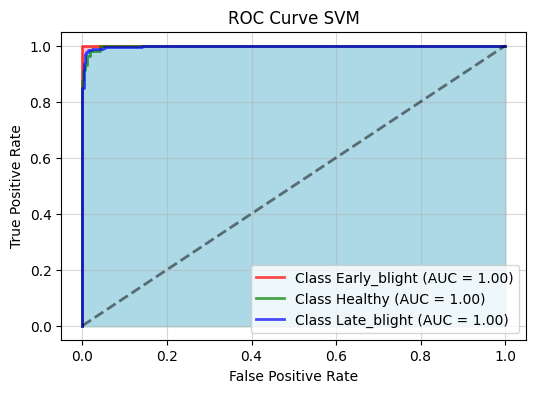

In [781]:
#plot roc curve
metrics.plot_roc_curve(y_test, y_scores, name = "SVM", save_fig = True, path = "roc_curve_svm.jpg")

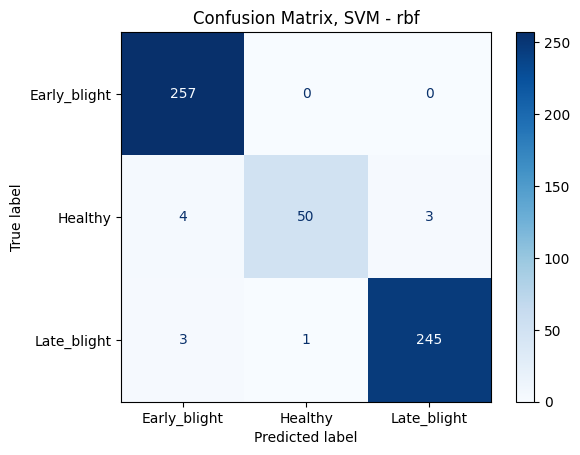

In [782]:
#plot confusion matrix
metrics.plot_confucion_matrix(y_test, y_pred, "Confusion Matrix, SVM - rbf", save_fig = True, path = "confusion_matrix_svm.jpg")

# Decision Tree

In [783]:
#get features and labels
X, y = df.drop(LBL, axis = 1), df.loc[:, LBL].to_numpy().astype("int")

y_bin = label_binarize(y, classes=[0, 1, 2])

In [784]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [785]:
#define and train a model
max_depth = 5
decision_tree = OneVsRestClassifier(DecisionTreeClassifier(random_state=RANDOM_STATE))

decision_tree.fit(X_train, y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(random_state=42))

In [786]:
#predict
y_pred = decision_tree.predict(X_test)

In [787]:
#get metrics
name = "decision tree"

metrics.update(name, y_test, y_pred)
metrics.set_average_time(name, decision_tree, X_test)
metrics.print_metrics(name)

Model name: decision tree
Accuracy: 0.77087.
Precision: 0.86642.
Recall: 0.85258.
F1_score: 0.85944.
Average time: 0.01095.


In [826]:
#get depth
# depth = decision_tree.get_depth()
# print(f"The depth of the model is {depth}.")

for i, estimator in enumerate(decision_tree.estimators_):
    print(f"Depth of Decision Tree for class {i + 1}: {estimator.get_depth()}")

Depth of Decision Tree for class 1: 11
Depth of Decision Tree for class 2: 8
Depth of Decision Tree for class 3: 16


In [789]:
#get y scores
y_scores = decision_tree.predict_proba(X_test)

In [790]:
#plot precision recall curve
#metrics.plot_precision_recall(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "precison_recall_curve_decision_tree.jpg")

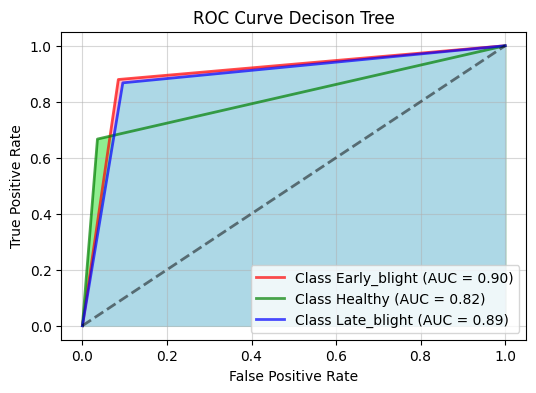

In [791]:
#plot roc curve
metrics.plot_roc_curve(y_test, y_scores, name = "Decison Tree", save_fig = True, path = "roc_curve_decision_tree.jpg")

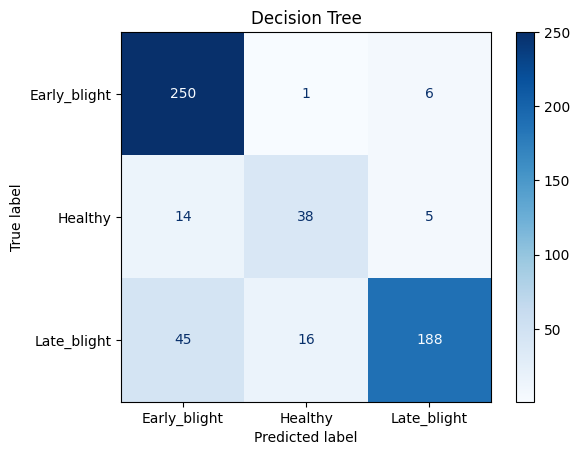

In [792]:
#plot confusion matrix
metrics.plot_confucion_matrix(y_test, y_pred, "Decision Tree", save_fig = True, path = "confusion_matrix_decision_tree.jpg")

# Naive Bayes

In [793]:
#get features and labels
X, y = df.drop(LBL, axis = 1), df.loc[:, LBL].to_numpy().astype("int")

y_bin = label_binarize(y, classes=[0, 1, 2])

In [794]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [795]:
#define and train model
naive_bayes = OneVsRestClassifier(GaussianNB())

naive_bayes.fit(X_train, y_train)

OneVsRestClassifier(estimator=GaussianNB())

In [796]:
#predict
y_pred = naive_bayes.predict(X_test)

In [797]:
#get metrics
name = "naive bayes"

metrics.update(name, y_test, y_pred)
metrics.set_average_time(name, naive_bayes, X_test)
metrics.print_metrics(name)

Model name: naive bayes
Accuracy: 0.84192.
Precision: 0.8814.
Recall: 0.95027.
F1_score: 0.91315.
Average time: 0.01889.


In [798]:
#get y scores
y_scores = naive_bayes.predict_proba(X_test)

In [799]:
#plot precision recall curve
#metrics.plot_precision_recall(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "precision_recall_curve_naive_bayes.jpg")

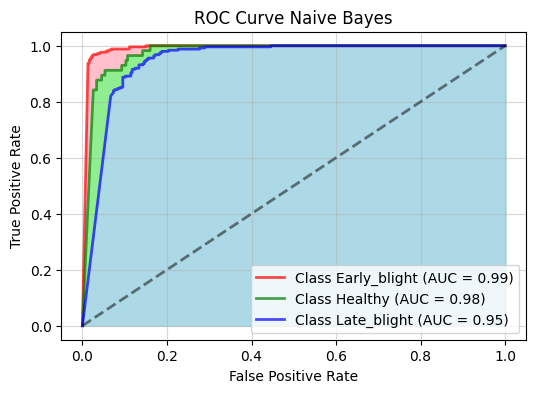

In [800]:
#plot roc curve
metrics.plot_roc_curve(y_test, y_scores, name = "Naive Bayes", save_fig = True, path = "roc_curve_naive_bayes.jpg")

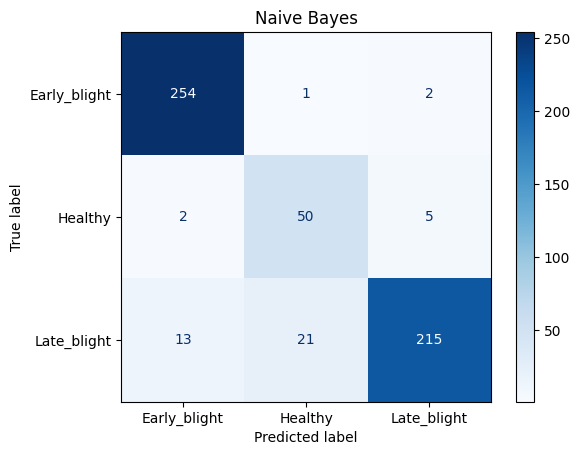

In [801]:
#plot confusion matrix
metrics.plot_confucion_matrix(y_test, y_pred, "Naive Bayes", save_fig = True, path = "confusion_matrix_naive_bayes.jpg")

# KNN

In [802]:
#get features and labels
robust = RobustScaler()

X, y = robust.fit_transform(df.drop(LBL, axis = 1)), df.loc[:, LBL].to_numpy().astype("int")

y_bin = label_binarize(y, classes=[0, 1, 2])

In [803]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=TEST_SIZE, random_state=RANDOM_STATE)

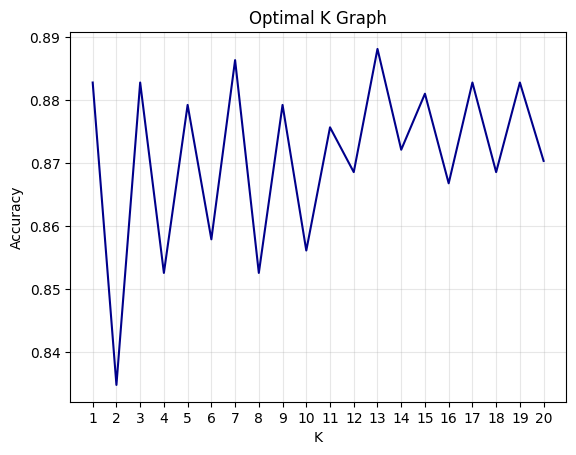

In [804]:
acc = []
k_values = np.arange(1,21)

for k in k_values:
    knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k))
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))

plt.plot(k_values, acc, c = "darkblue", zorder = 5)
plt.xticks(k_values)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Optimal K Graph")
plt.grid(alpha = 0.3, zorder = 1)
plt.savefig("knn_optimal_k.jpg")
plt.show()


In [805]:
#define and train model
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=7))

knn.fit(X_train, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier(n_neighbors=7))

In [806]:
#predict
y_pred = knn.predict(X_test)

In [807]:
#get metrics
name = "knn"

metrics.update(name, y_test, y_pred)
metrics.set_average_time(name, knn, X_test)
metrics.print_metrics(name)

Model name: knn
Accuracy: 0.88632.
Precision: 0.9349.
Recall: 0.88632.
F1_score: 0.89584.
Average time: 0.13938.


In [808]:
#get y scores
y_scores = knn.predict_proba(X_test)

In [809]:
#plot precision recall curve
#metrics.plot_precision_recall(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "precision_recall_knn.jpg")

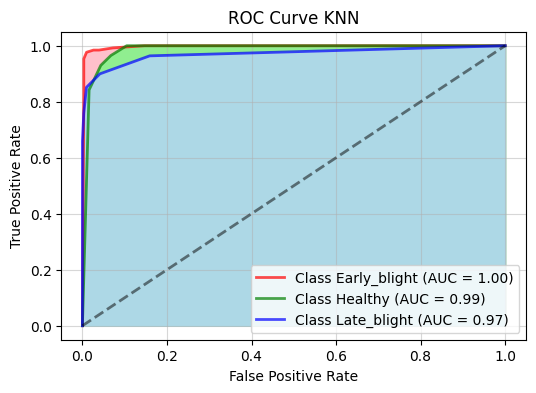

In [810]:
#plot roc curve
metrics.plot_roc_curve(y_test, y_scores, name = "KNN", save_fig = True, path = "roc_curve_knn.jpg")

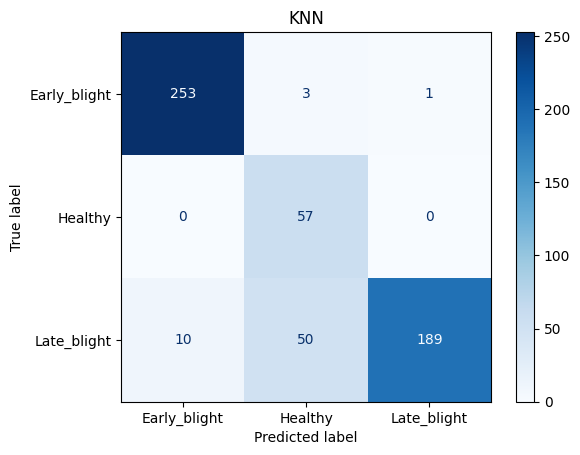

In [811]:
#plot confusion matrix
metrics.plot_confucion_matrix(y_test, y_pred, "KNN", save_fig = True, path = "confusion_matrix_knn.jpg")

# Perceptron

In [812]:
#get features and labels
X, y = df.drop(LBL, axis = 1), df.loc[:, LBL].to_numpy().astype("int")

y_bin = label_binarize(y, classes=[0, 1, 2])

In [813]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [814]:
#define and train model
perceptron = OneVsRestClassifier(Perceptron())

perceptron.fit(X_train, y_train)

OneVsRestClassifier(estimator=Perceptron())

In [815]:
#predict
y_pred = perceptron.predict(X_test)

In [816]:
#get metrics
name = "perceptron"

metrics.update(name, y_test, y_pred)
metrics.set_average_time(name, perceptron, X_test)
metrics.print_metrics(name)

Model name: perceptron
Accuracy: 0.94316.
Precision: 0.97149.
Recall: 0.96803.
F1_score: 0.96962.
Average time: 0.01101.


In [817]:
#get y scores
y_scores = perceptron.decision_function(X_test)

In [818]:
#plot precision recall curve
#metrics.plot_precision_recall(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "precision_recall_curve_perceptron.jpg")

In [819]:
#plot roc curve
#metrics.plot_roc_curve(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "roc_curve_perceptron.jpg")

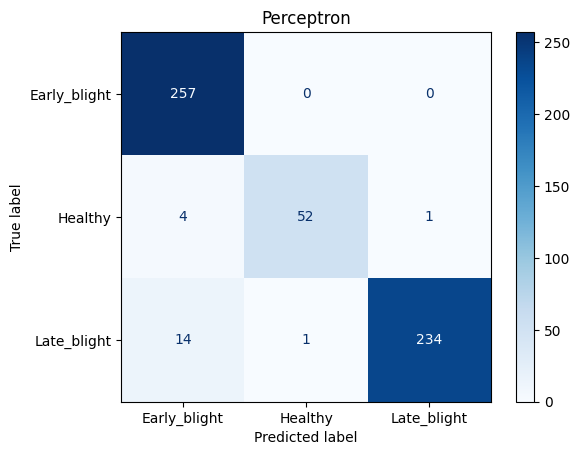

In [820]:
#plot confusion matrix
metrics.plot_confucion_matrix(y_test, y_pred, name.capitalize(), save_fig = True, path = "confusion_matrix_perceptron.jpg")

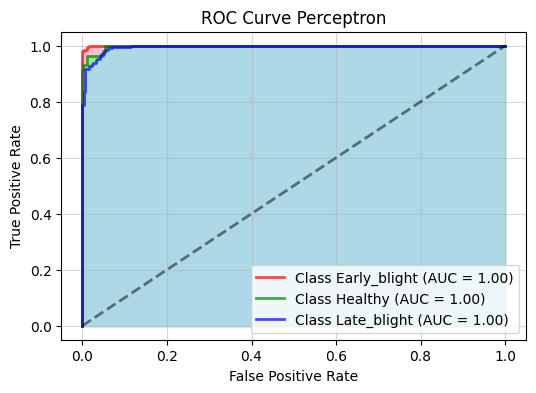

In [821]:
metrics.plot_roc_curve(y_test, y_scores, name = "Perceptron")

# All models

In [822]:
df_metrics = pd.DataFrame(metrics.get_metrics_dict()).T
df_metrics

,accuracy,precision,recall,f1_score,average time
svm,0.976909,0.989169,0.980462,0.984524,0.350218
decision tree,0.770870,0.866424,0.852575,0.859441,0.010955
naive bayes,0.841918,0.881403,0.950266,0.913150,0.018889
knn,0.886323,0.934900,0.886323,0.895839,0.139382
perceptron,0.943162,0.971488,0.968028,0.969625,0.011013


In [823]:
df_metrics_agg_columns = ["mean", "max_value_model", "max", "min_value_model", "min"]
df_metrics_agg = df_metrics.agg(["mean", "idxmax", "max", "idxmin", "min"]).T
df_metrics_agg.columns = df_metrics_agg_columns
df_metrics_agg

,mean,max_value_model,max,min_value_model,min
accuracy,0.883837,svm,0.976909,decision tree,0.77087
precision,0.928677,svm,0.989169,decision tree,0.866424
recall,0.927531,svm,0.980462,decision tree,0.852575
f1_score,0.924516,svm,0.984524,decision tree,0.859441
average time,0.106091,svm,0.350218,decision tree,0.010955


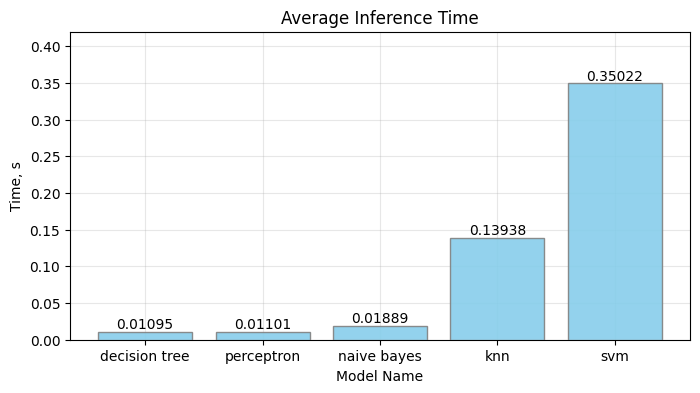

In [824]:
#number of instances is
average_time = df_metrics["average time"]

order_asc = average_time.argsort().values
xticks_labels = np.array([average_time.index[i] for i in order_asc])
height = np.array([average_time.values[i] for i in order_asc])

y_limit = (0, np.round(height.max() + height.max() * 0.2, 2))

fig = plt.figure(figsize = (8,4))

bars = plt.bar(xticks_labels, height, edgecolor = "grey", color = "skyblue",  alpha = 0.9, zorder = 5)

for bar in bars:
     h = bar.get_height()
     plt.text(bar.get_x() + bar.get_width() / 2, h, f'{round(h, 5)}', ha='center', va='bottom' )

plt.ylim(y_limit)
plt.grid(alpha = 0.3, zorder = 1)
plt.ylabel("Time, s")
plt.xlabel("Model Name")
plt.title("Average Inference Time")
plt.savefig("average_inference_time.jpg")
plt.show();
